## Hierarchical clustering
From the Clustering notebook I found out that the best result is returned with hierarchical clustering so here I will try to implement

In [1]:
import math
import pandas as pandas
import numpy as np
import matplotlib
import scipy.cluster.hierarchy as sch
from sklearn.metrics import silhouette_score
from math import floor, ceil
from scipy.cluster.hierarchy import single, cophenet
from scipy.spatial.distance import pdist, squareform
# matplotlib.use('Agg')
import matplotlib.pyplot as plt

data = pandas.read_json("../data/water_loss_data_set_1.json")

data = data[(data.timeStamp != "0000-00-00 00:00:00" ) & (data.timeStamp != "2000-01-01 00:00:00")] 
data = data[(data.tot1 != 0 ) & (data.analog2 != 0)]
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data["timeStamp"] = data["timeStamp"].dt.floor('h')
data["timeStamp"] = data["timeStamp"].dt.strftime("%Y-%m-%d %H:%M")
data["timeStamp"] = pandas.to_datetime(data["timeStamp"], format="%Y-%m-%d %H:%M")

data_249 = data[data['idflowmeter'] == "MAG8000_024905H318"]
data_248 = data[data['idflowmeter'] == "MAG8000_024805H318"]

data_249 = data_249.groupby("timeStamp").mean()
data_248 = data_248.groupby("timeStamp").mean()
data_248

,tot1,tot2,analog2
timeStamp,,,
2018-12-11 12:00:00,161.873400,0.00,0.819200
2018-12-11 13:00:00,264.282667,0.00,0.820333
2018-12-11 14:00:00,371.478000,0.00,0.818333
2018-12-11 15:00:00,487.519333,0.00,0.813167
2018-12-11 16:00:00,601.331833,0.00,0.810833
...,...,...,...
2020-04-01 10:00:00,977299.898333,-4713.21,1.527333
2020-04-01 11:00:00,977333.727167,-4713.21,1.528500
2020-04-01 12:00:00,977369.184833,-4713.21,1.530500


In [2]:
if type(data_249.index) == pandas.core.indexes.datetimes.DatetimeIndex:
    data_249.index = data_249.index.strftime("%Y-%m-%d %H:00")
    data_248.index = data_248.index.strftime("%Y-%m-%d %H:00")

def selected_data(data_fun, start, end):
    return data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]
    # "2020-01-20 00:00", "2020-01-24 23:00"
    
data_sel = selected_data(data_249, "2019-05-11 12:00:00", "2019-05-20 12:00:00")
data_all = selected_data(data_249, "2019-05-11 12:00:00", "2020-06-13 12:00:00")

matrix = data_sel.reset_index().values
matrix_X = matrix[:, 3:]             # try different variations of clustering, and with different attributes

matrix_all = data_all.reset_index().values
matrix_X_all = matrix_all[:, 3:]             # try different variations of clustering, and with different attributes
matrix_X_all

array([[0.8085000000000001],
       [0.8076666666666672],
       [0.806666666666667],
       ...,
       [0.8171666666666673],
       [0.8156666666666673],
       [0.8149999999999998]], dtype=object)

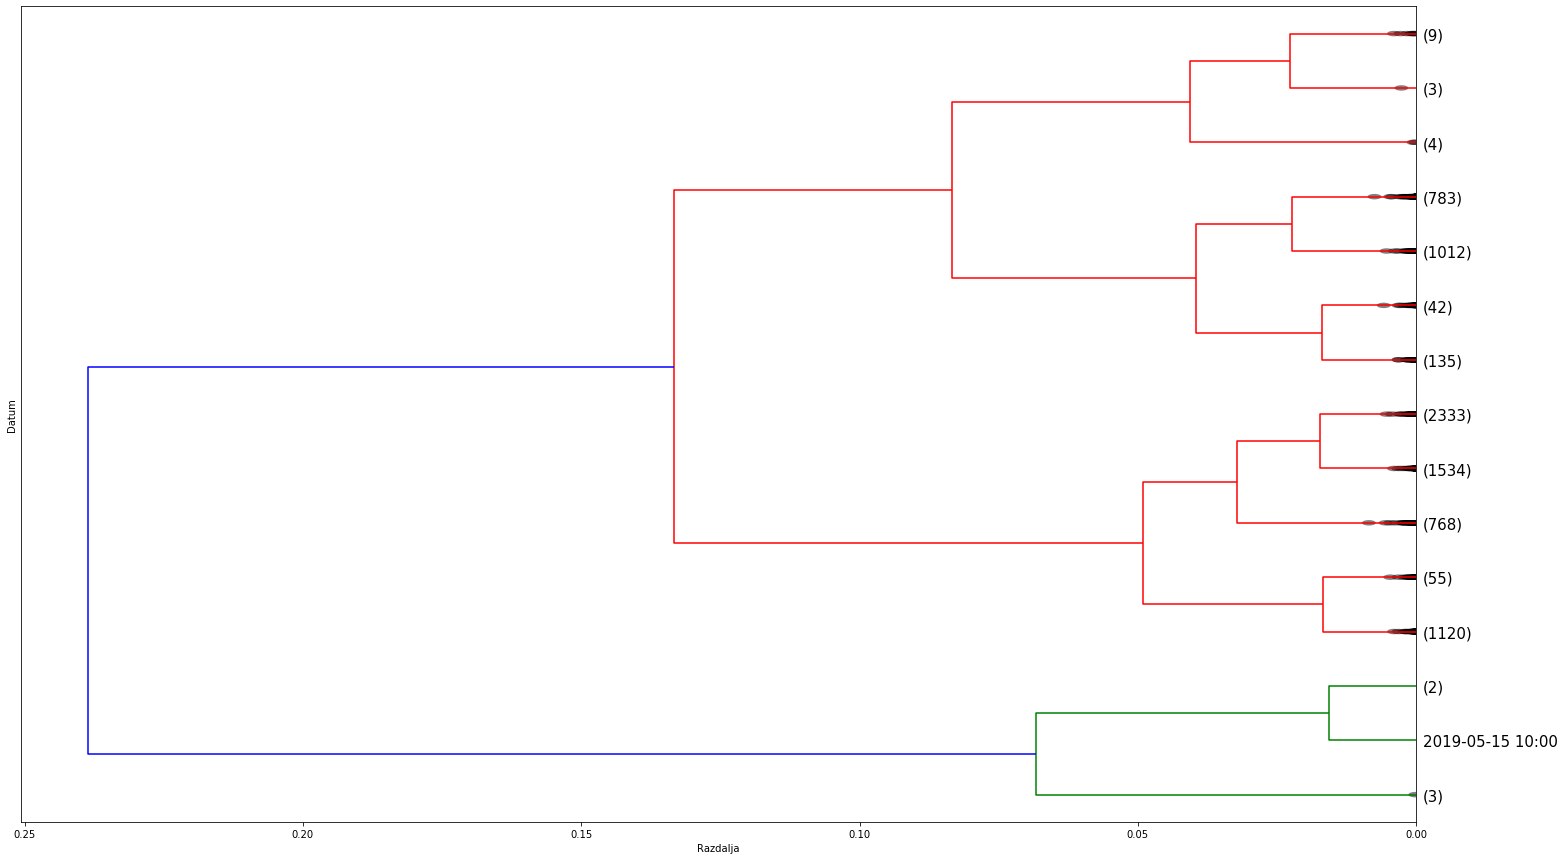

In [3]:
L = sch.linkage(matrix_X_all, method="complete", metric="cityblock")
plt.figure(figsize=(25, 15))

D  = sch.dendrogram(L, leaf_font_size=15, labels=matrix_all[:, 0], orientation="left", 
                        show_contracted=True, 
                        truncate_mode='lastp',  # last p merged clusters
                        p=15                    # show only the last p merged clusters
                       )
plt.xlabel("Razdalja")
plt.ylabel("Datum")
plt.show()

In [4]:

pdist(L[:100])
print(len(L))
print(len(matrix_X_all))
L[:1000]

7803
7804


array([[0.000e+00, 6.400e+01, 0.000e+00, 2.000e+00],
       [1.000e+00, 1.220e+03, 0.000e+00, 2.000e+00],
       [2.000e+00, 6.430e+02, 0.000e+00, 2.000e+00],
       ...,
       [5.042e+03, 8.800e+03, 0.000e+00, 1.470e+02],
       [5.043e+03, 8.801e+03, 0.000e+00, 1.480e+02],
       [5.044e+03, 8.802e+03, 0.000e+00, 1.490e+02]])

In [5]:
def find_optimal_t_cluster(L, matrix_fun, num_of_clusters):
    max_silhuete = [-1, 0]
    arr = []

    max_val = (floor(max(sch.maxdists(L)) * 100) / 100.0) * 0.66
    # print(max_val)
    t_f = max_val

    while(True):
        predictions = sch.fcluster(L, t=t_f, criterion="distance").ravel()
        score = round(silhouette_score(matrix_fun, predictions, metric="cityblock"), 3)
        arr.append((score, round(t_f, 4)))
        
        num_of_c = len(set(predictions))
        if num_of_c == num_of_clusters:
            max_silhuete[0] = score
            max_silhuete[1] = round(t_f, 4)
            break
        elif num_of_c < num_of_clusters:
            t_f = t_f - (t_f / 2)
        else:
            t_f = t_f + (t_f / 2)
        # print(t_f)

    print("The best value for t is t =", max_silhuete[1])
    return arr, t_f

In [6]:
arr_, t_best = find_optimal_t_cluster(L, matrix_X_all, 6)

predictions = sch.fcluster(L, t=t_best, criterion="distance").ravel()
print(set(predictions))

The best value for t is t = 0.0427
{1, 2, 3, 4, 5, 6}


In [7]:
def get_anomaly_coeficient(sorted_arr):
    return sorted_arr[len(sorted_arr) - 1][1] * 0.05

def generate_sizes(class_dict):
    class_len_arr = []
    for i in class_dict:
        class_len_arr.append([i, len(class_dict[i])])
        
    class_sorted_arr = sorted(class_len_arr, key=lambda x: x[1])
    
    size_arr = []
    anomaly_koef = get_anomaly_coeficient(class_sorted_arr)

    for i in class_len_arr:
        if i[1] <= anomaly_koef:
            size_arr.append(200)
            
        elif i[1] <= (anomaly_koef * 2):
            size_arr.append(100)
        else:
            size_arr.append(20)
        
    return size_arr

def generate_xticks(start_date, end_date):
    start_date = pandas._libs.tslibs.Timestamp(start_date) 
    end_date = pandas._libs.tslibs.Timestamp(end_date) 
    
    difference = ceil((ceil((end_date - start_date).days) / 10))
    date_range_seconds = pandas.date_range(start=(start_date), end=(end_date), freq=str(difference)+ "D")
    
    date_range_string = []
    for i in date_range_seconds:
        ready_string = str(i)[:-5] + "00"
        date_range_string.append(ready_string)  
        
    return date_range_string
    
# generate_xticks("2019-01-11 12:00:00", "2019-03-20 12:00:00")

In [90]:
# finding distance to anomalies
def predicting_anomalies(L, class_dict):
    class_len_arr = []
    for i in class_dict:
        class_len_arr.append([i, len(class_dict[i])])
        
    class_sorted_arr = sorted(class_len_arr, key=lambda x: x[1])
            
    distances = squareform(cophenet(L))
    # print("predicting distance ", distances[32][756])
    
    # Loop through edge classes, find the points closest to them
    anomaly_koef = get_anomaly_coeficient(class_sorted_arr)
    
    anomalies_classes = []
    main_classes = []
    for i in class_sorted_arr:
        if i[1] <= anomaly_koef:
            anomalies_classes.append(i)
        elif i[1] > (anomaly_koef * 4):
            # this are the main clusters
            main_classes.append(i[0])
            
    """vzamem ta velike razrede, in zracunam razdaljo drugih do njih, potem vzamem tiste ki so najbolj dalec kot anomalije. 
    Potem pa do teh zracunam razdalje vseh tistih ki niso taveliki         
    cluster_distance = maxdists(L)
    print("razlika med clustri ", len(cluster_distance), L)"""  
    
    distance_dict = dict()
    not_main_classes = [i[0] for i in class_sorted_arr if i[0] not in main_classes]
    
    # vkljuci linearno regresijo ... za ta glavne razrede
    for key_main in main_classes:
        for key_sub in not_main_classes:
            distance_dict[(key_main, key_sub)] = 0
            num_of_el = 0
            for main_el in class_dict[key_main]:
                for sub_el in class_dict[key_sub]:
                    # print(main_el, sub_el)
                    distance_dict[(key_main, key_sub)] += distances[main_el[0]][sub_el[0]]
                    num_of_el = num_of_el + 1
                    
            distance_dict[(key_main, key_sub)] = round(distance_dict[(key_main, key_sub)] / num_of_el, 5)        
                     
    possible_anomaly = set()
    mean_distance_dict = dict()
    for i in distance_dict:
        count = 0
        
        for j in distance_dict:
            if i[1] not in possible_anomaly and i[0] != j[0]:
                count += 1
                temp_sum = distance_dict[i] + distance_dict[j]
                
        if count != 0:
            mean_distance_dict[i[1]] = round(temp_sum / count, 4)
                    
        possible_anomaly.add(i[1])
    
    print(mean_distance_dict)
      

In [94]:
def draw_classes(matrix, matrix_X, class_dict, start, end):
    color_array = ["yellowgreen", "coral", "dodgerblue", "red", "springgreen", "aqua", 
                   "mistyrose", "deeppink", "bisque", "indigo"]
    size_arr = generate_sizes(class_dict)

    fig = plt.figure(figsize=(18, 12), dpi= 100, facecolor='w')
    plt.plot(matrix[:, 0], matrix_X, color="blue")
    
    for num, element in enumerate(class_dict):
        label_name = "Class: " + str(element) + " - Num of elements: " + str(len(class_dict[element]))
        plt.scatter([x[1] for x in class_dict[element]], [matrix_X[x[0]] for x in class_dict[element]], 
                    color=color_array[num], s=size_arr[num], 
                    label=label_name) 

    plt.ylabel('Pressure in bar ?')
    plt.xlabel('Date')
    plt.xticks(generate_xticks(start, end), rotation=40)
    plt.legend()
    
    plt.rc('xtick',labelsize=8)
    plt.title('Time')
    plt.show()


In [95]:
def main_function(start, end, data_fun, number_of_clusters):
    data_sel = data_fun.loc[(data_fun.index >= start) & (data_fun.index <= end)]    
    # "2020-01-20 00:00", "2020-01-24 23:00"
    
    matrix = data_sel.reset_index().values
    # print(matrix[:2])
    if len(matrix) < 1:
        raise Exception("No data for this date ") 
    matrix_X = matrix[:, 3:]        
    
    L = sch.linkage(matrix_X, method="complete", metric="cityblock")
    
    arr_, t_best = find_optimal_t_cluster(L, matrix_X, number_of_clusters)
    predictions = sch.fcluster(L, t=t_best, criterion="distance").ravel()

    """plt.figure(figsize=(25, 15))

    D  = sch.dendrogram(L, leaf_font_size=15, labels=matrix[:, 0], orientation="left", 
                            show_contracted=True, 
                            truncate_mode='lastp',  # last p merged clusters
                            p=number_of_clusters    # show only the last p merged clusters
                           )
    plt.xlabel("Razdalja")
    plt.ylabel("Datum")
    plt.show()"""
    
    class_dict = dict()

    for index, combined in enumerate(zip(matrix[:, 0], predictions)):
        value, predicted_class = combined
        if predicted_class not in class_dict:
            class_dict[predicted_class] = [(index, value)]
        else:
            class_dict[predicted_class].append((index, value))
     
    predicting_anomalies(L, class_dict)
    draw_classes(matrix, matrix_X, class_dict, start, end)

The best value for t is t = 0.0125
{5: 0.0313}


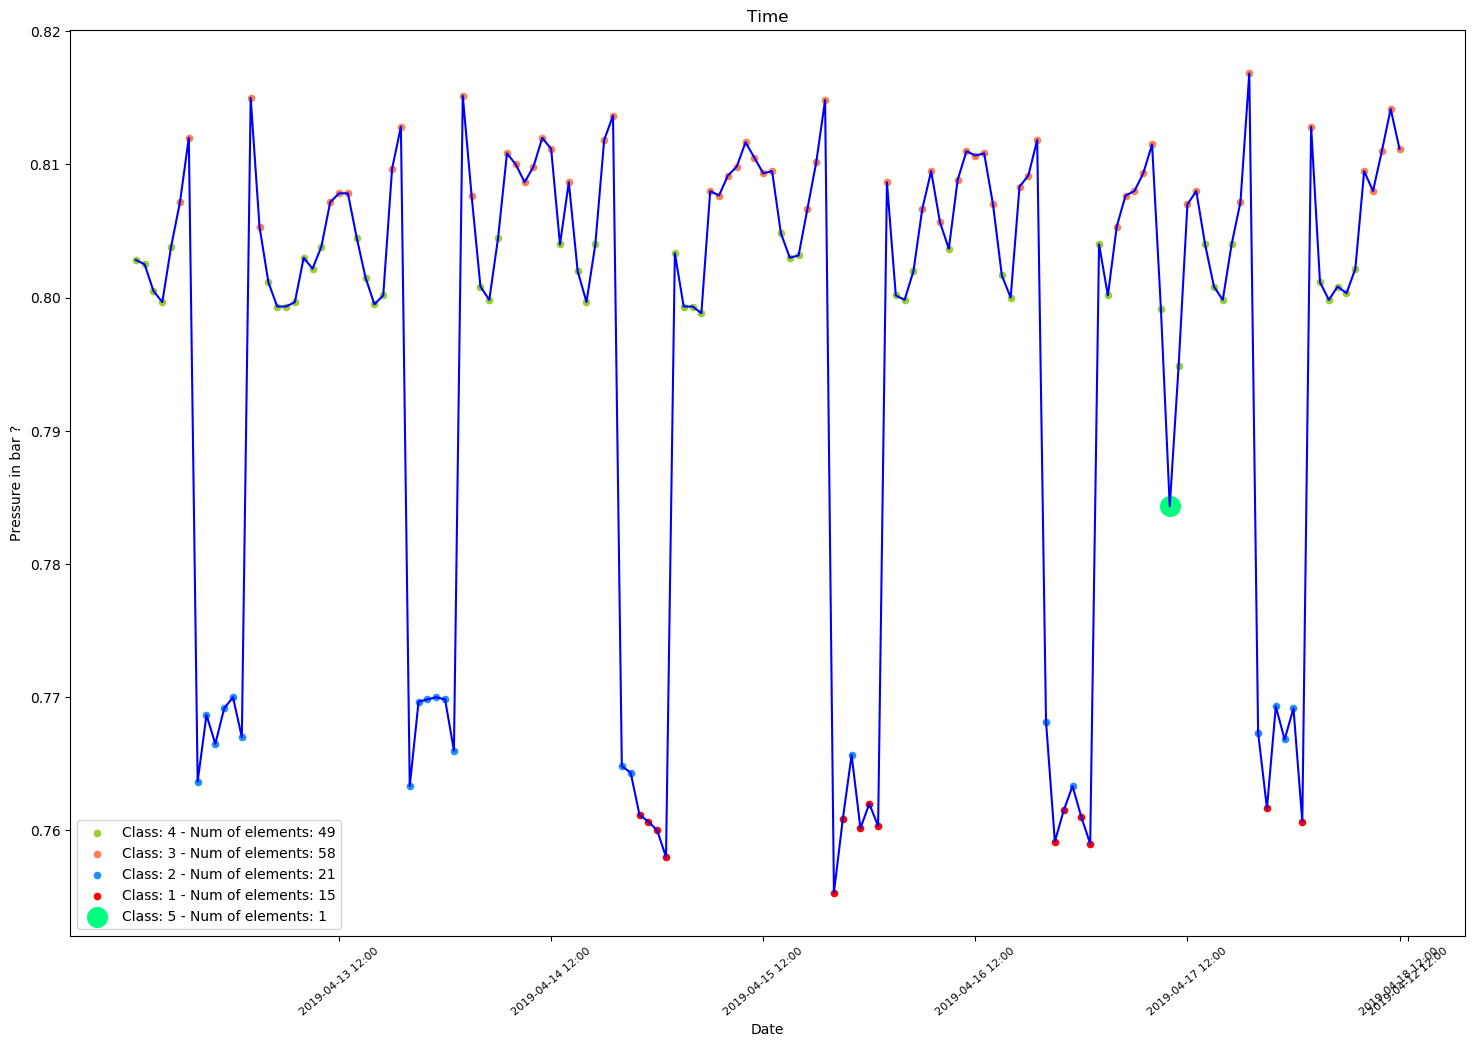

In [98]:
# selected_data(data_249, "2019-05-11 12:00:00", "2019-05-20 12:00:00")
# selected_data(data_249, "2019-05-11 12:00:00", "2020-06-13 12:00:00")

main_function("2019-04-12 12:00:00", "2019-04-18 12:00:00", data_249, 5)

This is pretty much it. Because of the lack of data or rather the explanation on what it means we can see that criteria for this classes could be set only with a few if-s that limit the range.

**// TODO find classes that lead to anomalies aka some state in between after which an abnormal state follows.**
**Anomalije so tiste ki so najbolj oddaljene od tistih z največjim številom točk.**